In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
%matplotlib inline 

import matplotlib.patches as mpatches
from PIL import Image
from skimage import io as skimgIO
from skimage.filters import (sobel, threshold_otsu)
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rotate,
                               hough_circle, hough_circle_peaks)
from skimage.exposure import histogram
from skimage.feature import canny, corner_harris, corner_peaks, corner_subpix, hog
from skimage.color import (rgb2gray, label2rgb)
from skimage.measure import (label, regionprops)
from skimage import morphology
import cv2 as cv

<class 'numpy.ndarray'> float64
0.7252802351409313


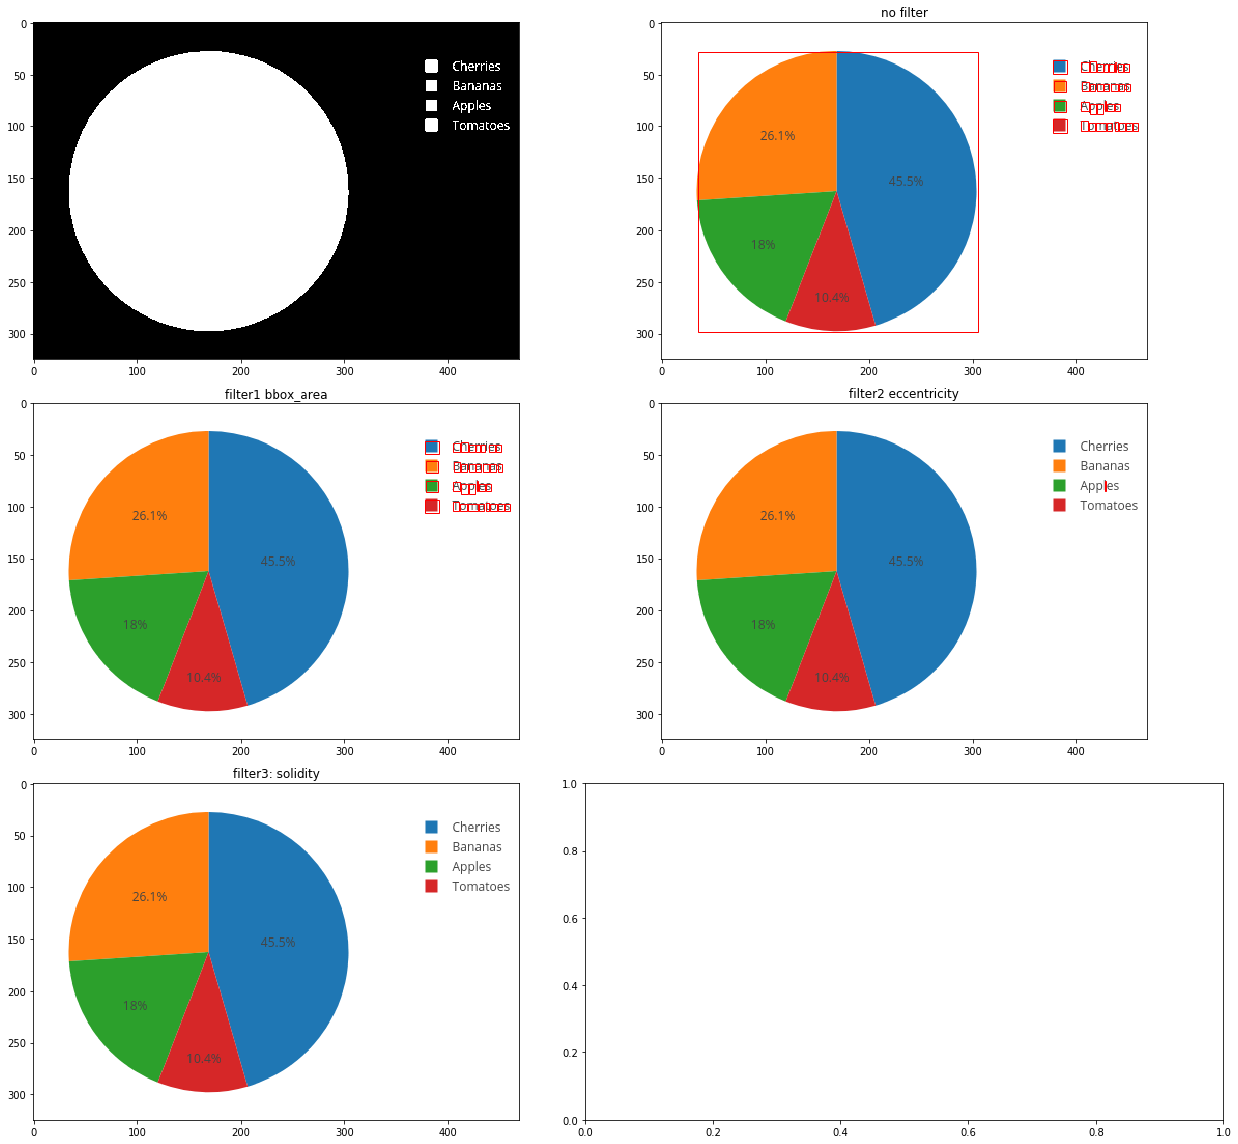

In [45]:
######
# 字符筛选条件实验
####
#img_path = './data_test/line_img_failed/real_line_16.png'
img_path = 'data_test/web_collected_test/real_pie/image/real_pie_20.png'
img_ori = skimgIO.imread(img_path)  
img_H, img_W,_  = img_ori.shape
#img_bgr = cv.cvtColor(img_ori, cv.COLOR_RGB2BGR)

# 字符筛选条件
img_gray = rgb2gray(img_ori)   #<class 'numpy.ndarray'>
print(type(img_gray), img_gray.dtype)
# 二值化
thresh = threshold_otsu(img_gray)
print(thresh)
img_binary = img_gray < thresh

fig, ax = plt.subplots(3,2, figsize=(18,16))
ax = ax.ravel()
ax[0].imshow(img_binary, cmap=c_map.gray)

label_img, label_num = label(img_binary, background=None, return_num=True, connectivity=2)
#image_label_overlay = label2rgb(label_img, image=img_binary)
#plt.imshow(image_label_overlay)

chara_bbox_cent = []
chara_bbox = []
chara_bbox_area = []
chara_area = []
label_rm = []
img_height, img_width = img_binary.shape

ax[1].imshow(img_ori)
ax[1].set_title("no filter")

ax[2].imshow(img_ori)
ax[2].set_title("filter1 bbox_area")

ax[3].imshow(img_ori)
ax[3].set_title("filter2 eccentricity")

ax[4].imshow(img_ori)
ax[4].set_title("filter3: solidity")

# see https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
for region in regionprops(label_img):  # remove warning in 0.14 vs 0.16
    
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)
    # filter1: take regions with large enough areas
    if (img_height*img_width)//40 >=region.bbox_area >= 8 :
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
        ax[2].add_patch(rect)
        
        #filter2: 离心率
        if region.eccentricity >= 0.993:
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            ax[3].add_patch(rect)
            
        if (region.bbox_area > 40 and region.solidity <0.9) or region.bbox_area <=40:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            #ax[].add_patch(rect)
            chara_bbox_cent.append(region.centroid)
            chara_bbox.append(region.bbox)
            chara_bbox_area.append(region.bbox_area)
            chara_area.append(region.area)
            
            
        else:
            label_rm.append(region.label)
    else:
        label_rm.append(region.label)

#plt.title(' Connection Components & Bboxes')
#ax.set_axis_off()
# plt.savefig(name)
plt.tight_layout()

In [ ]:
import os
temp_text_bbox_root = "./txt_bbox_img-temp"
if not os.path.exists(temp_text_bbox_root):
    os.mkdir(temp_text_bbox_root)


for i,bbox in enumerate(txt_bbox):
    txt_img = np.ones_like(img_show)*255
    txt_img[bbox[0]:bbox[2], bbox[1]:bbox[3], :3] = img_show[bbox[0]:bbox[2], bbox[1]:bbox[3], :3]
    ((centx,centy), (w,h), angle) = txt_minRect_info[i] 
    w = int(w); h = int(h)
    h,w,_ = txt_img.shape
    centx = int(centx); centy = int(centy)
    if angle != 0:
        M = cv.getRotationMatrix2D((centx,centy), angle, 1.0)
        rotated = cv.warpAffine(txt_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    else:
        rotated = txt_img.copy()
    
    temp_img = Image.fromarray(rotated)
    temp_img.save("txt_bbox_img-temp/"+str(i)+".png")

In [ ]:
import os
import pyocr
import pyocr.builders as ocrtools
ocr_tool = pyocr.get_available_tools()[0]
assert ocr_tool is not None, "no ocr_tool acailable!!!"

In [ ]:
#将每个文本框还原在原图中再ocr
temp_text_bbox_root = "./txt_bbox_img-temp"
if not os.path.exists(temp_text_bbox_root):
    os.mkdir(temp_text_bbox_root)
txt_ocr = []
for i, bbox in enumerate(txt_bbox):
    pre_img_array = np.ones_like(img_ori)*255
    pre_img_array[bbox[0]:bbox[2], bbox[1]:bbox[3], :] = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    temp_img = Image.fromarray(pre_img_array)
    temp_img.save("txt_bbox_img-temp/"+str(i)+".png")
    
    #ocr
    txt = ocr_tool.image_to_string(temp_img, lang="eng", builder=ocrtools.DigitBuilder())    
    txt_ocr.append(txt)
    
print(txt_ocr)


In [ ]:
#将每个文本框直接调用ocr接口识别
temp_text_bbox_root = "./txt_bbox_img-temp"
if not os.path.exists(temp_text_bbox_root):
    os.mkdir(temp_text_bbox_root)
    
txt_ocr = []
for i, bbox in enumerate(txt_bbox):
    pre_img_array = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    temp_img = Image.fromarray(pre_img_array)
    temp_img.save("txt_bbox_img-temp/"+str(i)+".png")
    
    #ocr
    txt = ocr_tool.image_to_string(temp_img, lang="eng", builder=ocrtools.DigitBuilder())    
    txt_ocr.append(txt)
    
print(txt_ocr)


In [ ]:
#将提取出来的文本框拼接到一起
txt_bbox.pop(3)
print(txt_bbox)
txt_bbox_h = [item[2]-item[0] for item in txt_bbox]
txt_bbox_w = [item[3]-item[1] for item in txt_bbox] 
max_h = max(txt_bbox_h)
max_w = max(txt_bbox_w)
print(max_h,max_w)
lst_crop = []
for bbox in txt_bbox:
    bbox_img_crop = np.ones((max_h,max_w,3), dtype= np.uint8)*255
    bbox_h = bbox[2]-bbox[0]
    bbox_w = bbox[3]-bbox[1]
    bbox_img_crop[:bbox_h,:bbox_w,:] = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    lst_crop.append(bbox_img_crop)
    
img_crop = np.concatenate(lst_crop, axis=0, )
print(img_crop.shape, img_crop.dtype)
img_crop_save = Image.fromarray(img_crop)
img_crop_save.save("img_crop_save.png")

In [ ]:
# ocr文本识别
import pyocr
import pyocr.builders as ocrtools
ocr_tool = pyocr.get_available_tools()[0]
assert ocr_tool is not None, "no ocr_tool acailable!!!"

txt_ocr = []
for i, bbox in enumerate(txt_bbox):
    
    pre_img_array = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    # 将竖向文本旋转90度  
    #h,w,~ = pre_img_array.shape
    txt_4d = [ocr_tool.image_to_string(Image.fromarray(np.rot90(pre_img_array,k,(0,1))),
                                       lang="eng",builder=ocrtools.TextBuilder())
              for k in range(4)]
    
    txt_ocr.append(txt_4d)


In [ ]:
import pytesseract as ptocr
txt_ocr = []
for i, bbox in enumerate(txt_bbox):
    pre_img_array = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    txt_4d = [ptocr.image_to_string(Image.fromarray(np.rot90(pre_img_array,k,(0,1)))) for k in range(4)]
    txt_ocr.append(txt_4d)

In [ ]:
# test pytesseract
import pytesseract as ptocr

ret_boxes = ptocr.image_to_boxes(Image.fromarray(skimgIO.imread("img_crop_save.png")))
ret_data = ptocr.image_to_data(Image.fromarray(skimgIO.imread("img_crop_save.png")))
ptocr.image_to_osd()

ret_data

txt_ocr